#Imports



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import pandas as pd

import torch as tc 
from sklearn.utils import shuffle
import torch.nn as nn
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import utils,datasets
from torch.utils.data import Dataset, DataLoader,random_split
import cv2
import torchvision.models as models

#Colab Stuff

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/data.zip" -d "/data/"

Streaming output truncated to the last 5000 lines.
  inflating: /data/data/train/without_mask/without_mask_888.jpg  
  inflating: /data/__MACOSX/data/train/without_mask/._without_mask_888.jpg  
  inflating: /data/data/train/without_mask/without_mask_136.jpg  
  inflating: /data/__MACOSX/data/train/without_mask/._without_mask_136.jpg  
  inflating: /data/data/train/without_mask/without_mask_2500.jpg  
  inflating: /data/__MACOSX/data/train/without_mask/._without_mask_2500.jpg  
  inflating: /data/data/train/without_mask/without_mask_122.jpg  
  inflating: /data/__MACOSX/data/train/without_mask/._without_mask_122.jpg  
  inflating: /data/data/train/without_mask/without_mask_1009.jpg  
  inflating: /data/__MACOSX/data/train/without_mask/._without_mask_1009.jpg  
  inflating: /data/data/train/without_mask/without_mask_644.jpg  
  inflating: /data/__MACOSX/data/train/without_mask/._without_mask_644.jpg  
  inflating: /data/data/train/without_mask/without_mask_3178.jpg  
  inflating: /data/_

In [ ]:
path = "/data/data/"
!ls "/data/data/"
train_path = "/data/data/train/"
test_path = "/data/data/test/"

test  train


In [ ]:
np.random.seed(0)
tc.manual_seed(0)

In [ ]:
print(train_path,test_path)


/data/data/train/ /data/data/test/


## Get the mean and Std



In [ ]:
get_mean = transforms.Compose([
              transforms.Resize((224,224)),
              transforms.ToTensor()
    ])


In [ ]:
train_dataset = datasets.ImageFolder(
    root = train_path,transform=get_mean
)
train_dataset

Dataset ImageFolder
    Number of datapoints: 6461
    Root location: /data/data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
           )

In [ ]:
import warnings
warnings.filterwarnings("ignore")
dl = DataLoader(dataset=train_dataset, batch_size=len(train_dataset),num_workers=2)
dt = next(iter(dl))
mean = dt[0].mean()
std = dt[0].std()
print(mean,std)


tensor(0.5288) tensor(0.3050)


#Image Transformations

In [ ]:
img_transform = transforms.Compose([
              transforms.Resize((224,224)),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
    ])

#The Dataset

In [ ]:
train_dataset = datasets.ImageFolder(
    root = train_path,transform=img_transform
)
train_dataset

Dataset ImageFolder
    Number of datapoints: 6461
    Root location: /data/data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=0.528849184513092, std=0.3050268888473511)
           )

In [ ]:
test_dataset = datasets.ImageFolder(
    root = test_path,
    transform = img_transform
)
test_dataset

Dataset ImageFolder
    Number of datapoints: 1092
    Root location: /data/data/test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=0.528849184513092, std=0.3050268888473511)
           )

In [ ]:
train_dataset.classes

['with_mask', 'without_mask']

In [ ]:
train_dataset.class_to_idx
test_dataset.class_to_idx

{'with_mask': 0, 'without_mask': 1}

In [ ]:
idx2class1 = {i: j for j,i in
             train_dataset.class_to_idx.items()}
idx2class2 = {i: j for j,i in
             test_dataset.class_to_idx.items()}
idx2class1
idx2class2

{0: 'with_mask', 1: 'without_mask'}

In [ ]:
def get_distribution(obj,idx2class):
  count_dict = {i:0 for i,j in obj.class_to_idx.items()}
  for k in obj:
    ylbl = k[1]
    ylbl = idx2class[ylbl]
    count_dict[ylbl] += 1
  return count_dict

print ("distribution train: "  , get_distribution(train_dataset,idx2class1))
print ("distribution test: "  , get_distribution(test_dataset,idx2class2))


distribution train:  {'with_mask': 3179, 'without_mask': 3282}
distribution test:  {'with_mask': 546, 'without_mask': 546}


In [ ]:
print(train_dataset.classes, len(train_dataset), len(train_dataset.classes))
print(test_dataset.classes ,len(test_dataset), len(test_dataset.classes))

['with_mask', 'without_mask'] 6461 2
['with_mask', 'without_mask'] 1092 2


#The Dataloader

In [ ]:
tr_dl = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32,num_workers=2)
te_dl = DataLoader(dataset=test_dataset, shuffle=False, batch_size=32,num_workers=2)
print("Length of the train_loader:", len(tr_dl))
print("Length of the val_loader:", len(te_dl))


Length of the train_loader: 202
Length of the val_loader: 35


#Helper function to show image

In [ ]:
def show_img(im, ax=None, figsize=(8,8), title=None):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3) 
    ax.imshow(im);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if title: ax.set_title(title)
    return ax

In [ ]:
xb,yb = next(iter(tr_dl))
xb.shape

torch.Size([32, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


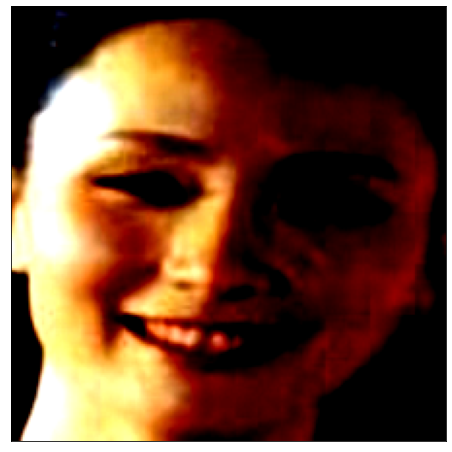

In [ ]:
show_img(xb[2].numpy().transpose(1,2,0))

In [ ]:
accuracy = lambda y_,yb: (y_.max(dim=1)[1] == yb).float().mean()

#Helper function for training

In [ ]:
def one_epoch(net, loss, dl, opt=None, metric=None):
    
    if opt:
        net.train()  # only affects some layers
    else:
        net.eval()
        rq_stored = []
        for p in net.parameters():
            rq_stored.append(p.requires_grad)
            p.requires_grad = False
    
    L, M = [], []
    dl_it = iter(dl)
    for xb, yb in tqdm(dl_it, leave=False):
        xb, yb = xb.cuda(), yb.cuda()
        y_ = net(xb)
        l = loss(y_, yb)
        if opt:
            opt.zero_grad()
            l.backward()
            opt.step()
        L.append(l.detach().cpu().numpy())
        if metric: M.append(metric(y_, yb).cpu().numpy())
        
    if not opt:
        for p,rq in zip(net.parameters(), rq_stored): p.requires_grad = rq
            
    return L, M    

def fit(net, tr_dl, val_dl, loss=nn.CrossEntropyLoss(), epochs=10, lr=3e-3, wd=1e-3, plot=True):   
    
    opt = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
    Ltr_hist, Lval_hist = [], []
    for epoch in trange(epochs):
        Ltr,  _    = one_epoch(net, loss, tr_dl,  opt)
        Lval, Aval = one_epoch(net, loss, val_dl, None, accuracy)
        Ltr_hist.append(np.mean(Ltr))
        Lval_hist.append(np.mean(Lval))
        print(f'epoch: {epoch}\ttraining loss: {np.mean(Ltr):0.4f}\tvalidation loss: {np.mean(Lval):0.4f}\tvalidation accuracy: {np.mean(Aval):0.2f}')
        
    # plot the losses     
    if plot:
        _,ax = plt.subplots(1,1,figsize=(16,4))
        ax.plot(1+np.arange(len(Ltr_hist)),Ltr_hist)
        ax.plot(1+np.arange(len(Lval_hist)),Lval_hist)
        ax.grid('on')
        ax.set_xlim(left=1, right=len(Ltr_hist))
        ax.legend(['training loss', 'validation loss']);
        
    return Ltr_hist, Lval_hist


#Resnet 18 without pretrained

In [ ]:
resnt18 = models.resnet18().cuda()

In [ ]:
resnt18.fc

In [ ]:
resnt18.fc = nn.Linear(512,2).cuda()

epoch: 0	training loss: 0.2275	validation loss: 0.9065	validation accuracy: 0.66


epoch: 1	training loss: 0.1973	validation loss: 0.2847	validation accuracy: 0.91


epoch: 2	training loss: 0.1865	validation loss: 1.1543	validation accuracy: 0.74


epoch: 3	training loss: 0.1742	validation loss: 0.3215	validation accuracy: 0.88


epoch: 4	training loss: 0.1479	validation loss: 0.2183	validation accuracy: 0.92


epoch: 5	training loss: 0.1362	validation loss: 1.4997	validation accuracy: 0.67


epoch: 6	training loss: 0.1282	validation loss: 0.2966	validation accuracy: 0.88


epoch: 7	training loss: 0.1158	validation loss: 0.2671	validation accuracy: 0.90


epoch: 8	training loss: 0.1070	validation loss: 0.1958	validation accuracy: 0.92


epoch: 9	training loss: 0.0997	validation loss: 0.2583	validation accuracy: 0.89

CPU times: user 2min 28s, sys: 14 s, total: 2min 42s
Wall time: 5min 59s


([0.22749859,
  0.19731435,
  0.18652098,
  0.17423373,
  0.14793283,
  0.13615124,
  0.1282056,
  0.11580605,
  0.107021354,
  0.099717304],
 [0.90654236,
  0.28470534,
  1.1542928,
  0.32152465,
  0.21828316,
  1.4996833,
  0.29663628,
  0.2671186,
  0.19576529,
  0.25834125])

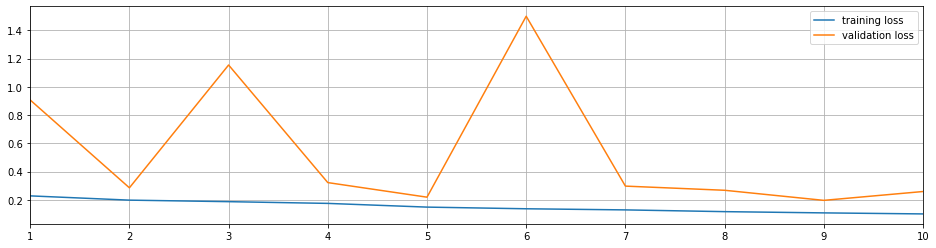

In [ ]:
%%time
fit(resnt18,tr_dl,te_dl,epochs=10,lr=0.001)

#Resnet18 pretrained

In [ ]:
resnet18 = models.resnet18(pretrained=True).cuda()

In [ ]:
resnet18.fc = nn.Linear(512,2).cuda()

epoch: 0	training loss: 0.0936	validation loss: 0.1194	validation accuracy: 0.96


epoch: 1	training loss: 0.0737	validation loss: 0.1026	validation accuracy: 0.95


epoch: 2	training loss: 0.0765	validation loss: 0.1425	validation accuracy: 0.93


epoch: 3	training loss: 0.0654	validation loss: 0.1120	validation accuracy: 0.96


epoch: 4	training loss: 0.0693	validation loss: 0.1766	validation accuracy: 0.94


epoch: 5	training loss: 0.0605	validation loss: 0.1628	validation accuracy: 0.96


epoch: 6	training loss: 0.0506	validation loss: 0.0792	validation accuracy: 0.98


epoch: 7	training loss: 0.0467	validation loss: 0.1238	validation accuracy: 0.96


epoch: 8	training loss: 0.0700	validation loss: 0.0743	validation accuracy: 0.97


epoch: 9	training loss: 0.0439	validation loss: 0.0957	validation accuracy: 0.97

CPU times: user 6min 47s, sys: 24.1 s, total: 7min 11s
Wall time: 9min 42s


([0.09361399,
  0.073721245,
  0.07653204,
  0.06538627,
  0.06927319,
  0.060518418,
  0.05055708,
  0.04669578,
  0.070043184,
  0.043892294],
 [0.11943227,
  0.10256322,
  0.1425141,
  0.11196604,
  0.176591,
  0.16275957,
  0.07924861,
  0.123782605,
  0.074298285,
  0.09567202])

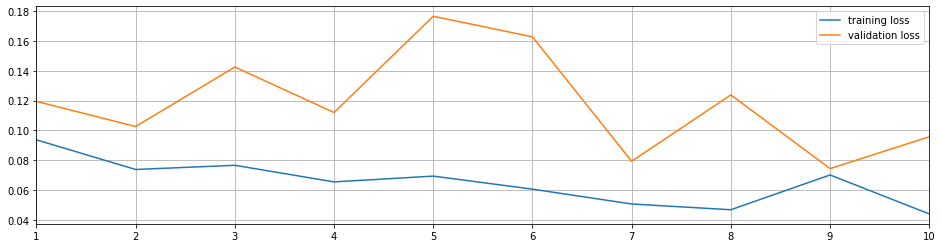

In [ ]:
%%time
fit(resnet18, tr_dl, te_dl, epochs=10,lr=0.001);

In [ ]:
tc.save(resnet18.state_dict(), 'resnet18.pth')

#Get the frontal face detection cascade

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

--2021-05-26 12:50:11--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2021-05-26 12:50:11 (34.1 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
print( face_cascade.empty() )

False


#Test the model on a real world image

Image predicted as without mask


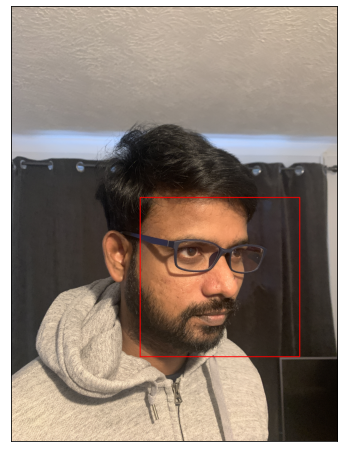

In [ ]:
from PIL import Image
import random
import os

if tc.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

model = resnet18  
model.load_state_dict(tc.load('resnet18.pth'))  
model.eval()  

transform = img_transform 

import urllib
#url = "https://media.allure.com/photos/5e34ab188a385400093f2a16/3:4/w_1500,h_2000,c_limit/mask.jpg"
#url = "https://i.pinimg.com/280x280_RS/bb/d6/93/bbd6938a8b6c0715b5facbaa365ae6fd.jpg"
#url = "https://i.insider.com/5e583363fee23d3fd10eac33"

# With Mask
#url = "http://nishphotography.com/dataset/IMG_3312.JPG"
#url = "http://nishphotography.com/dataset/IMG_3313.JPG"
#url = "http://nishphotography.com/dataset/IMG_3314.JPG"
#url = "http://nishphotography.com/dataset/IMG_3315.JPG"
#url = "http://nishphotography.com/dataset/IMG_3316.JPG"
#url = "http://nishphotography.com/dataset/IMG_3317.JPG"
#url = "http://nishphotography.com/dataset/IMG_3318.JPG"
#url = "http://nishphotography.com/dataset/IMG_3319.JPG"
#url = "http://nishphotography.com/dataset/IMG_3320.JPG"
#url = "http://nishphotography.com/dataset/IMG_3321.JPG"
#url = "http://nishphotography.com/dataset/IMG_3322.JPG"
#url = "http://nishphotography.com/dataset/IMG_3323.JPG"
#url = "http://nishphotography.com/dataset/IMG_3324.JPG"
#url = "http://nishphotography.com/dataset/IMG_3325.JPG"
#url = "http://nishphotography.com/dataset/IMG_3326.JPG"
#url = "http://nishphotography.com/dataset/IMG_3327.JPG"
#url = "http://nishphotography.com/dataset/IMG_3328.JPG"
#url = "http://nishphotography.com/dataset/IMG_3329.JPG"
#url = "http://nishphotography.com/dataset/IMG_3330.JPG"
#url = "http://nishphotography.com/dataset/IMG_3331.JPG"
#url = "http://nishphotography.com/dataset/IMG_3332.JPG"
#url = "http://nishphotography.com/dataset/IMG_3333.JPG"
#url = "http://nishphotography.com/dataset/IMG_3334.JPG"

# Without Mask
#url = "http://nishphotography.com/dataset/IMG_3335.JPG"
#url = "http://nishphotography.com/dataset/IMG_3336.JPG"
#url = "http://nishphotography.com/dataset/IMG_3337.JPG"
#url = "http://nishphotography.com/dataset/IMG_3338.JPG"
#url = "http://nishphotography.com/dataset/IMG_3339.JPG"
#url = "http://nishphotography.com/dataset/IMG_3340.JPG"
#url = "http://nishphotography.com/dataset/IMG_3341.JPG"
#url = "http://nishphotography.com/dataset/IMG_3342.JPG"
#url = "http://nishphotography.com/dataset/IMG_3343.JPG"
#url = "http://nishphotography.com/dataset/IMG_3344.JPG"
#url = "http://nishphotography.com/dataset/IMG_3345.JPG"
#url = "http://nishphotography.com/dataset/IMG_3346.JPG"
#url = "http://nishphotography.com/dataset/IMG_3347.JPG"
response = urllib.request.urlopen(url)
image = np.asarray(bytearray(response.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
faces = face_cascade.detectMultiScale(image,1.1,4,minSize = (500, 500))
img = Image.fromarray(image, 'RGB')
x = transform(img)  
x = x.unsqueeze(0).cuda() 

output = model(x) 
pred = tc.argmax(output, 1)  
if pred==1:
  for (x,y,w,h) in faces:
    cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),8)
  print('Image predicted as without mask')
  show_img(image)
else:
  for (x,y,w,h) in faces:
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),8)
  print('Image predicted as with mask')
  show_img(image)

#Compare different models

#Alexnet

In [ ]:
alexnet = models.alexnet(pretrained=True).cuda()
alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
alexnet.classifier[6] = nn.Linear(4096,2).cuda()

epoch: 0	training loss: 15.3520	validation loss: 0.6937	validation accuracy: 0.49


epoch: 1	training loss: 8.2015	validation loss: 0.6965	validation accuracy: 0.49


epoch: 2	training loss: 0.6938	validation loss: 0.6929	validation accuracy: 0.51


epoch: 3	training loss: 0.6936	validation loss: 0.6952	validation accuracy: 0.49


epoch: 4	training loss: 0.6933	validation loss: 0.6928	validation accuracy: 0.51

CPU times: user 39.5 s, sys: 7.13 s, total: 46.6 s
Wall time: 2min 40s


([15.352019, 8.201515, 0.6938386, 0.6935902, 0.6932719],
 [0.6936976, 0.69646865, 0.6928655, 0.6952487, 0.69283485])

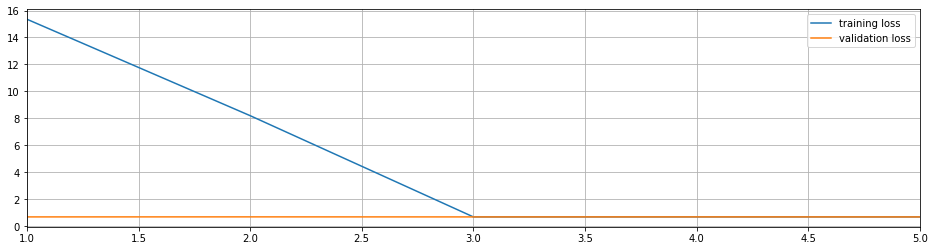

In [ ]:
%%time
fit(alexnet, tr_dl, te_dl, epochs=5, lr=0.001)

#DenseNet 161

In [ ]:
densenet = models.densenet161(pretrained=True).cuda()
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
densenet.classifier = nn.Linear(2208, 2).cuda()

epoch: 0	training loss: 0.1293	validation loss: 0.2582	validation accuracy: 0.94


epoch: 1	training loss: 0.0950	validation loss: 0.3406	validation accuracy: 0.87


epoch: 2	training loss: 0.0819	validation loss: 0.0790	validation accuracy: 0.97


epoch: 3	training loss: 0.0741	validation loss: 0.0857	validation accuracy: 0.97


epoch: 4	training loss: 0.0752	validation loss: 0.1111	validation accuracy: 0.96



([0.12926298, 0.094972074, 0.08194765, 0.07411811, 0.0751819],
 [0.25823474, 0.3406326, 0.078968294, 0.08568809, 0.11107794])

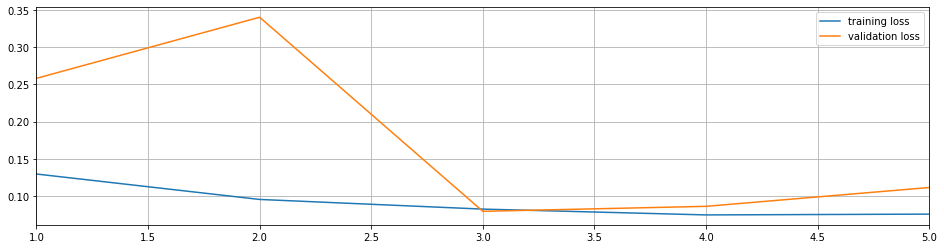

In [ ]:
%%time
fit(densenet,tr_dl,te_dl,epochs=5,lr=0.001)

#Mobilenet v3

In [ ]:
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True).cuda()
mobilenet_v3_small

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [ ]:
mobilenet_v3_small.classifier[0] = nn.Linear(576,1024).cuda()
mobilenet_v3_small.classifier[3] = nn.Linear(1024,2).cuda()

epoch: 0	training loss: 0.0374	validation loss: 0.4308	validation accuracy: 0.94


epoch: 1	training loss: 0.0254	validation loss: 1.2402	validation accuracy: 0.49


epoch: 2	training loss: 0.0219	validation loss: 1.0999	validation accuracy: 0.49


epoch: 3	training loss: 0.0269	validation loss: 0.5440	validation accuracy: 0.62


epoch: 4	training loss: 0.0300	validation loss: 0.7374	validation accuracy: 0.49

CPU times: user 55.2 s, sys: 7.67 s, total: 1min 2s
Wall time: 2min 48s


([0.037359595, 0.025430892, 0.021891406, 0.02686009, 0.029961286],
 [0.43079585, 1.2402011, 1.0999143, 0.5440371, 0.7373724])

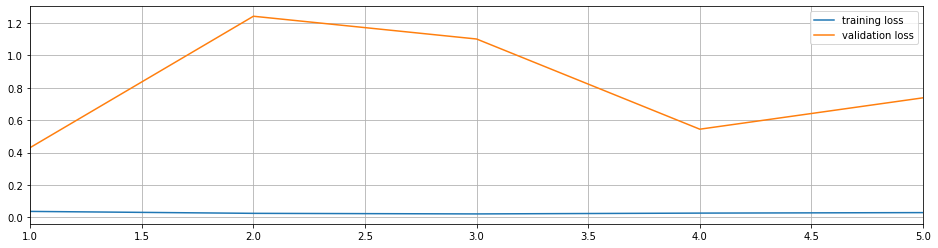

In [ ]:
%%time
fit(mobilenet_v3_small,tr_dl,te_dl,epochs=5,lr=0.001)